In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
import matplotlib.transforms as mtransforms
from matplotlib.figure import Figure
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

#DataSet Split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
#Gradient Boosting
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error, r2_score
#Naive Linear Regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
#Trigonometric features
from sklearn.preprocessing import FunctionTransformer
#Periodic Spline Features
from sklearn.preprocessing import SplineTransformer
#Pairwise interactions with splines and polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
#Non-Linear feature interactions with kernels
from sklearn.kernel_approximation import Nystroem

from sklearn.linear_model import LinearRegression

from numpy.fft import rfft, irfft, rfftfreq
from scipy import signal, fftpack

from statsmodels.tsa.seasonal import seasonal_decompose

data = pd.read_csv("../data/daily_sunspots_time_series_1850-01_2024-05.csv", parse_dates=['date'])
data.set_index('date', inplace = True)
data = data.drop('indicator', axis = 1)
import time


## 1. Exploration of the data set: Columns, period, basic plots

We will start identifying the natural period of the solar cycle

In [3]:
data = data.drop(['date_frac', 'std', 'nobs'], axis = 1)

In [4]:
def annot_max(x,y,ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text = f"x = {xmax:.3f}, y = {ymax:.3f}, (period: {(1./xmax):.2f} days)"
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle = "square, pad =0.3", fc = "w", ec = "k", lw = 0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)

In [5]:
n_obs = len(data.counts)
sunspot_ft = np.abs(rfft(data.counts))
sunspot_freq = rfftfreq(n_obs)
sunspot_ft

array([5.31097600e+06, 6.61147375e+05, 5.12496025e+05, ...,
       2.70621870e+03, 1.69472842e+03, 4.56426509e+03])

In [6]:
sunspot_freq

array([0.00000000e+00, 1.57052440e-05, 3.14104880e-05, ...,
       4.99960737e-01, 4.99976442e-01, 4.99992147e-01])

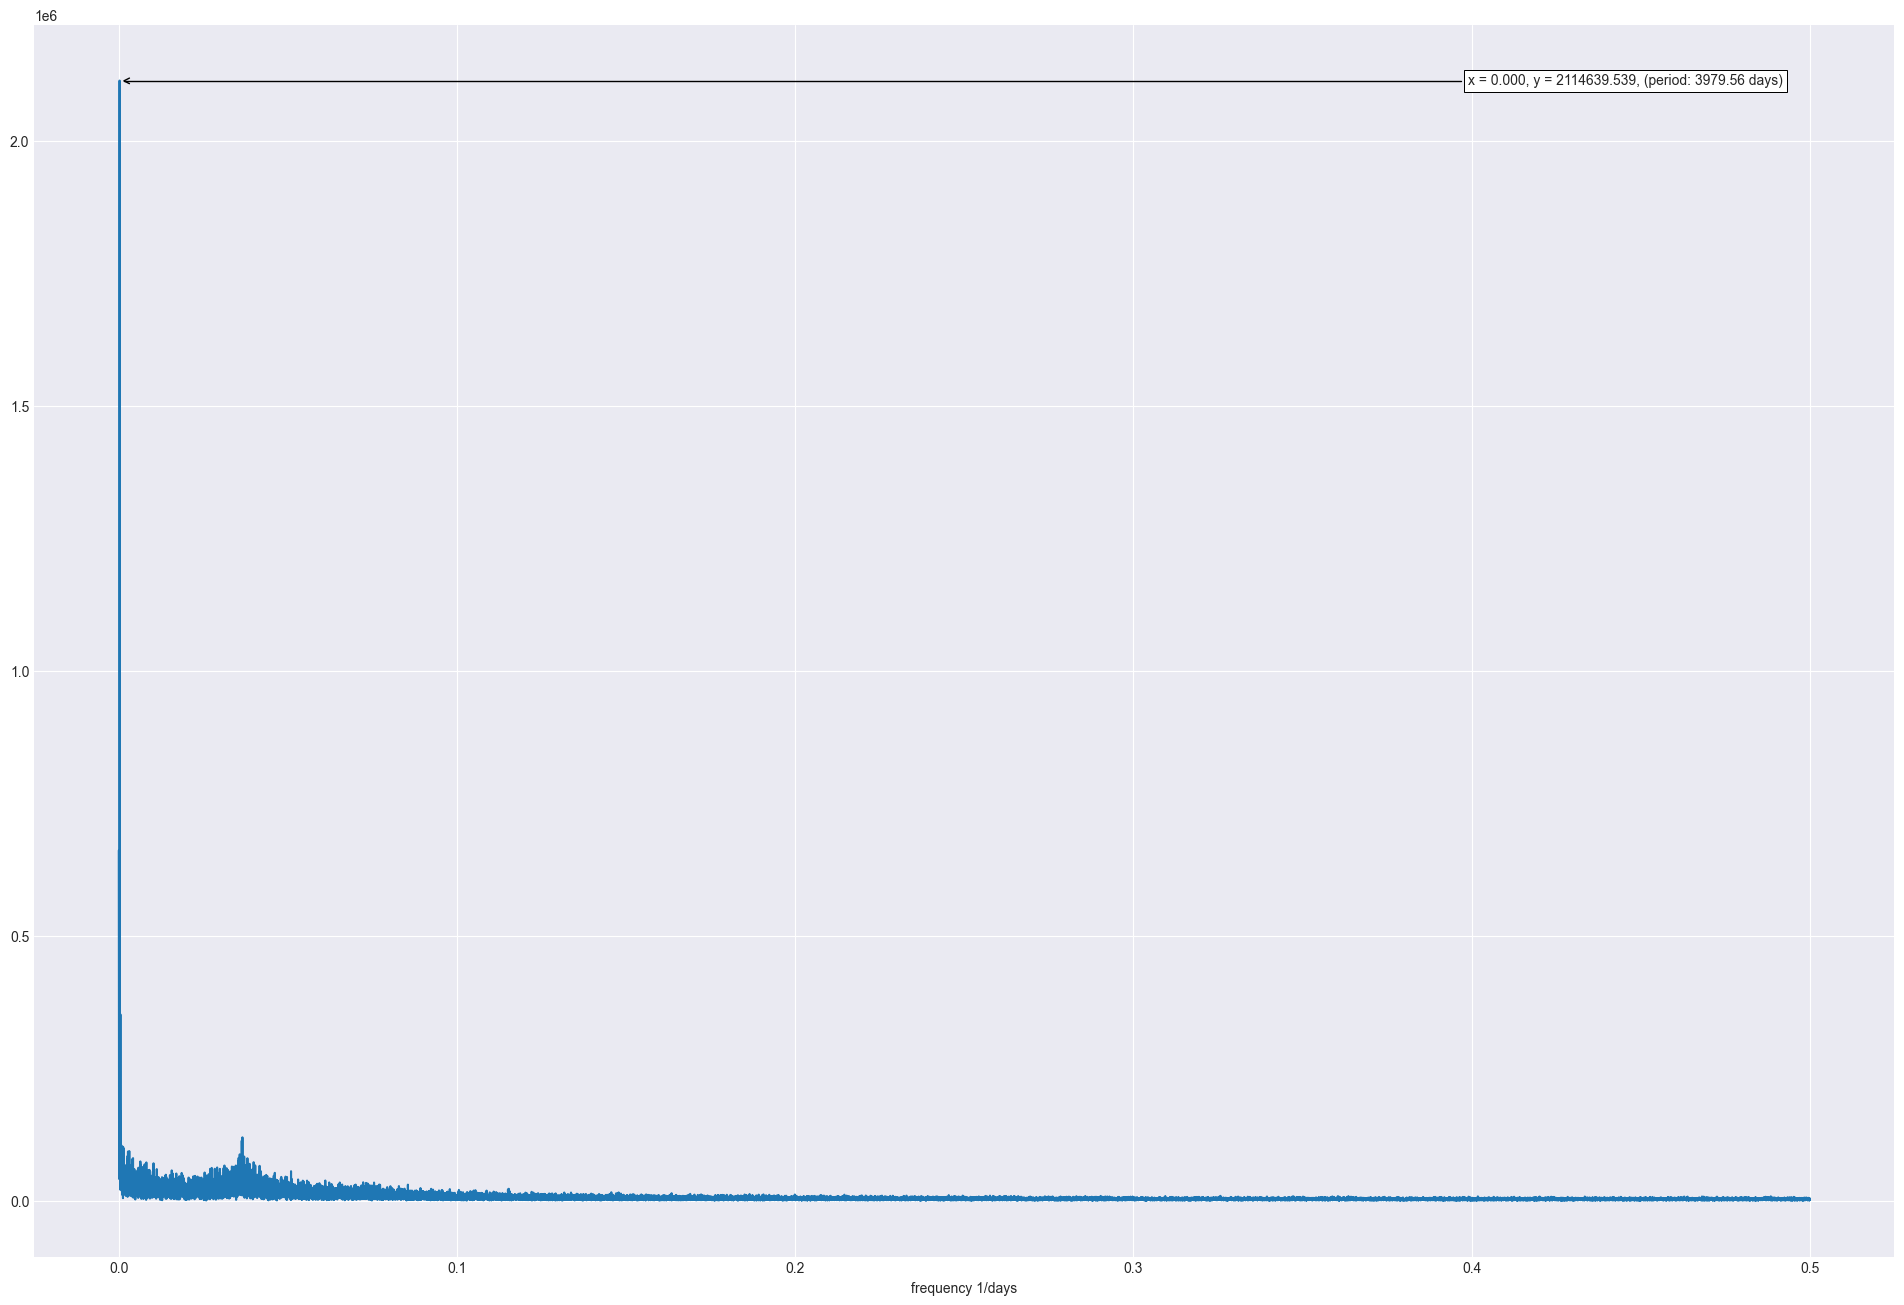

In [7]:
plt.figure(figsize=(24,16))
plt.plot(sunspot_freq[1:], sunspot_ft[1:])
annot_max(sunspot_freq[1:], sunspot_ft[1:])

plt.xlabel('frequency 1/days')
plt.show()

We see that the period of the solarcycle is $$T=3979\hspace{0.2cm} \text{days}$$

In [8]:
sp = pd.DataFrame({'freqency [1/day]':sunspot_freq[1: ], 'y':sunspot_ft[1: ]})
sp['period [days]'] = (1/sp['freqency [1/day]'])

sp_sort = sp.sort_values(by=['y'], ascending=False)#.head()#.to_csv('seasonality.csv', index=False)
sp_sort.query('y>100000')


freqency [1/day]             y  period [days]
15            0.000251  2.114640e+06    3979.562500
16            0.000267  8.967146e+05    3745.470588
17            0.000283  6.639532e+05    3537.388889
0             0.000016  6.611474e+05   63673.000000
14            0.000236  5.757567e+05    4244.866667
1             0.000031  5.124960e+05   31836.500000
3             0.000063  4.733001e+05   15918.250000
19            0.000314  3.959381e+05    3183.650000
31            0.000503  3.515802e+05    1989.781250
7             0.000126  3.483085e+05    7959.125000
21            0.000346  3.151480e+05    2894.227273
13            0.000220  3.119652e+05    4548.071429
20            0.000330  2.863618e+05    3032.047619
2             0.000047  2.789648e+05   21224.333333
18            0.000298  2.191643e+05    3351.210526
33            0.000534  2.161217e+05    1872.735294
12            0.000204  2.058956e+05    4897.923077
5             0.000094  1.952209e+05   10612.166667
29            0.000471  1.809875e+05    2122.433333
32            0.000518  1.772437e+05    1929.484848
4             0.000079  1.724165e+05   12734.600000
35            0.000565  1.680476e+05    1768.694444
10            0.000173  1.641809e+05    5788.454545
26            0.000424  1.503970e+05    2358.259259
25            0.000408  1.487844e+05    2448.961538
30            0.000487  1.472644e+05    2053.967742
9             0.000157  1.403966e+05    6367.300000
11            0.000188  1.292953e+05    5306.083333
23            0.000377  1.274971e+05    2653.041667
8             0.000141  1.268408e+05    7074.777778
2328          0.036578  1.194432e+05      27.339201
2315          0.036373  1.130300e+05      27.492660
42            0.000675  1.052583e+05    1480.767442
49            0.000785  1.040645e+05    1273.460000
81            0.001288  1.015159e+05     776.500000

In [9]:
T1 = int(1/sunspot_freq[1:][np.argmax(sunspot_ft[1:])])
T2 = sp_sort['period [days]'][16]
T3 = sp_sort['period [days]'][17]
T4 = sp_sort['period [days]'][0]
T5 = sp_sort['period [days]'][14]
T6 = sp_sort['period [days]'][1]
T7 = sp_sort['period [days]'][3]

*Low Pass function*

array([           inf, 2.00000000e-03, 1.00000000e-03, ...,
       6.28259094e-08, 6.28239359e-08, 6.28219626e-08])

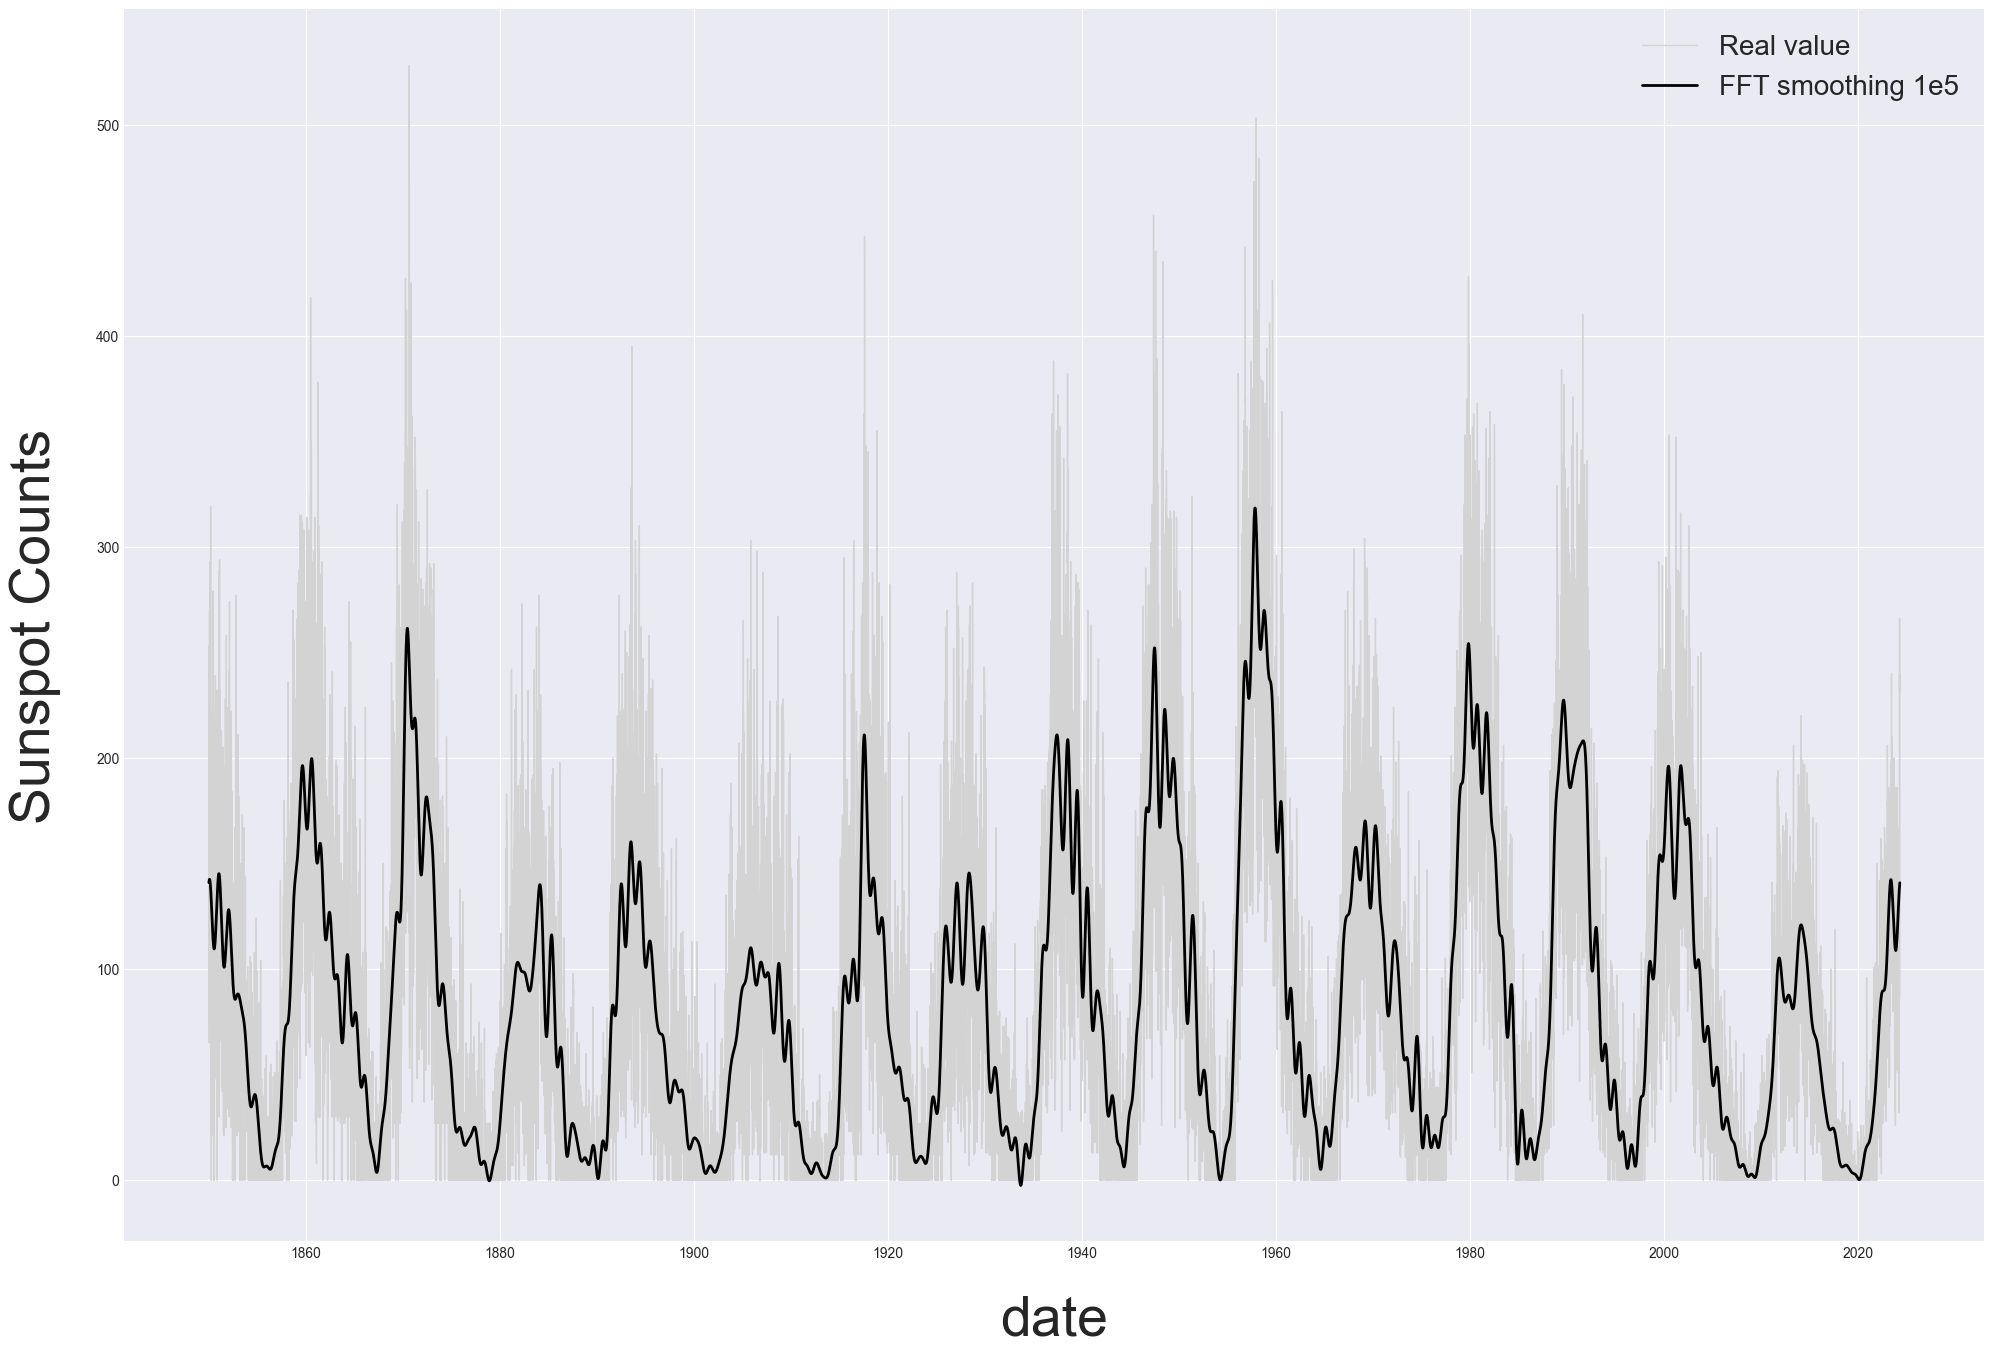

In [10]:
def low_pass(s, threshold=1e5):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    display(1/frequencies)
    fourier[frequencies > threshold] = 0
    return irfft(fourier, len(s))

data['counts_smoothed'] = low_pass(data['counts'])

fig = plt.figure(figsize=(24,16))
plt.plot(data['counts'], linewidth=1, color = 'lightgrey')
plt.plot(data.counts_smoothed, linewidth=2, color = 'black')

plt.xlabel('date',fontsize=40, labelpad=25)
plt.ylabel('Sunspot Counts',fontsize=40, labelpad=25)
plt.legend(['Real value','FFT smoothing 1e5'], prop={'size': 20})
plt.title('',fontsize=40, pad=30)                  
plt.show()


*Decomposition using stats*

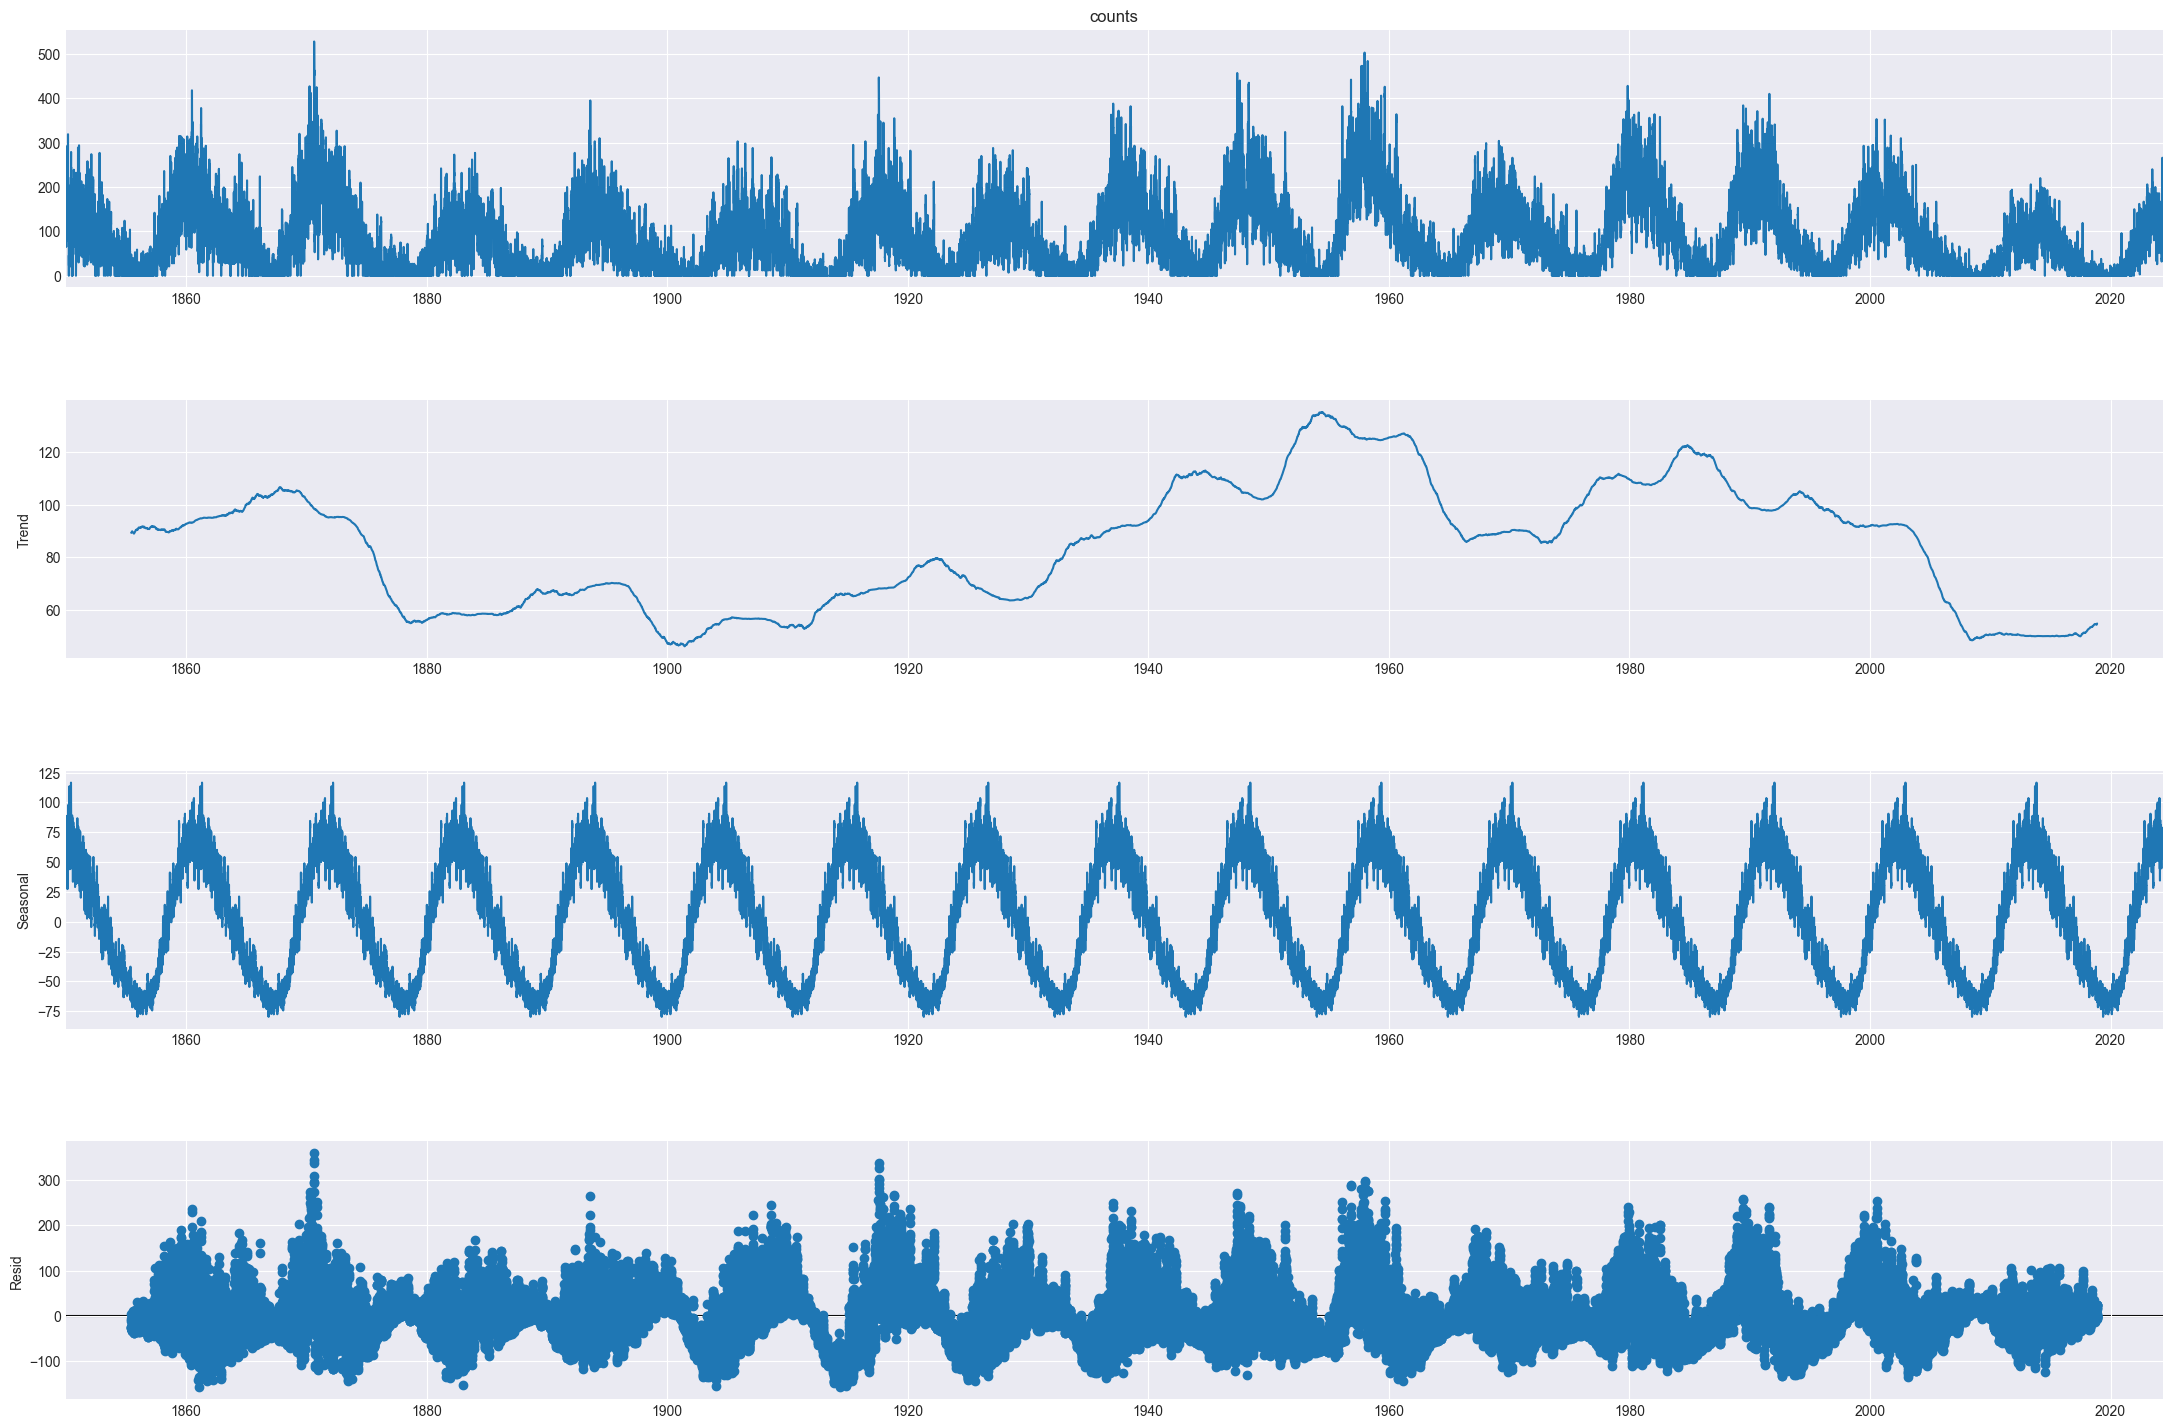

In [13]:
decomposition = seasonal_decompose(data.counts, model = 'add', period = T1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig = decomposition.plot()
fig.set_size_inches((24, 16))
plt.show()

**Analizing the type of Time Series**

In [15]:
def qcd_variance(series, window = T1):
    """This function returns the quartile coefficient of 
        disopersion of the rolling variance of a series in a given window range
    """
    #rolling variance for a given window
    variances = series.rolling(window).var().dropna()
    #first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    #third quatile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    #quartile coefficient of dispersion
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    print(f"quartile coefficient of dispersion: {qcd}")

qcd_variance(data.counts)

quartile coefficient of dispersion: 0.349389


It seems that we have a multiplicative time series.
Let's impelement a transformation of the data

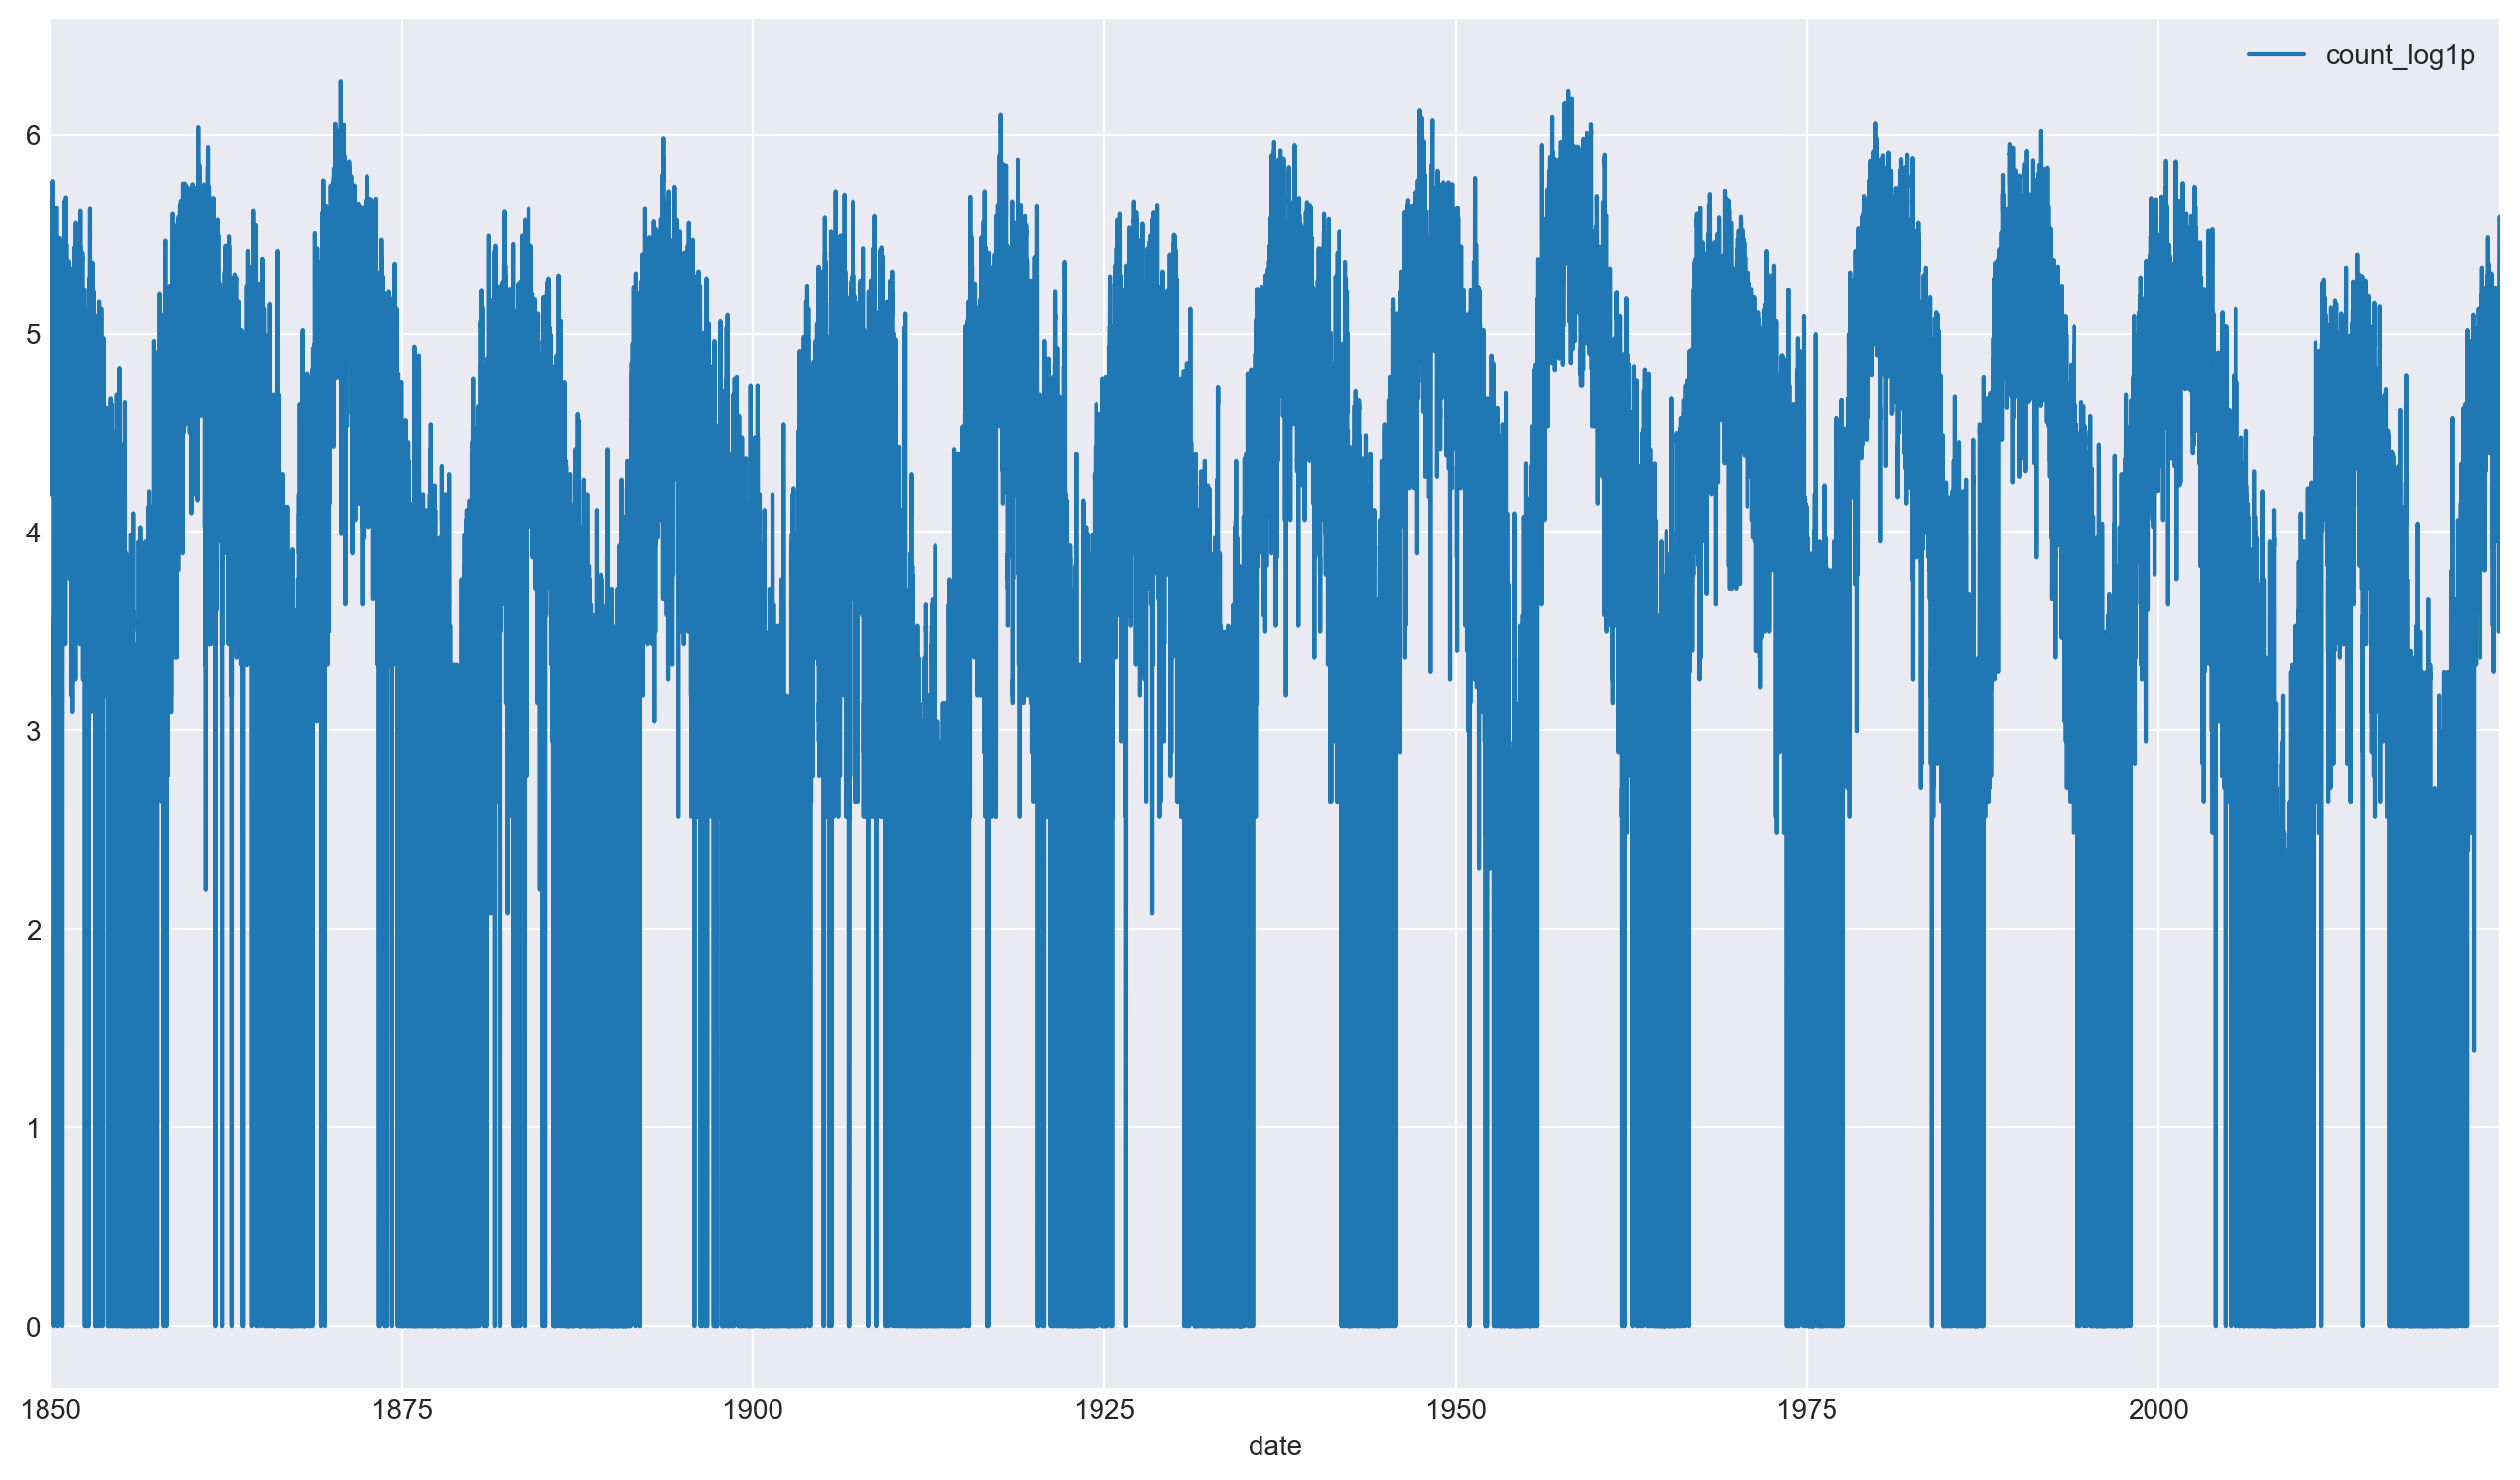

In [20]:
# Log transform
data['counts_log1p'] = np.log1p(data.counts)
mpl.rc('figure',figsize=(16,9),dpi=200)
data['count_log1p'].plot(legend=True)
sns.despine()

The Transformed data

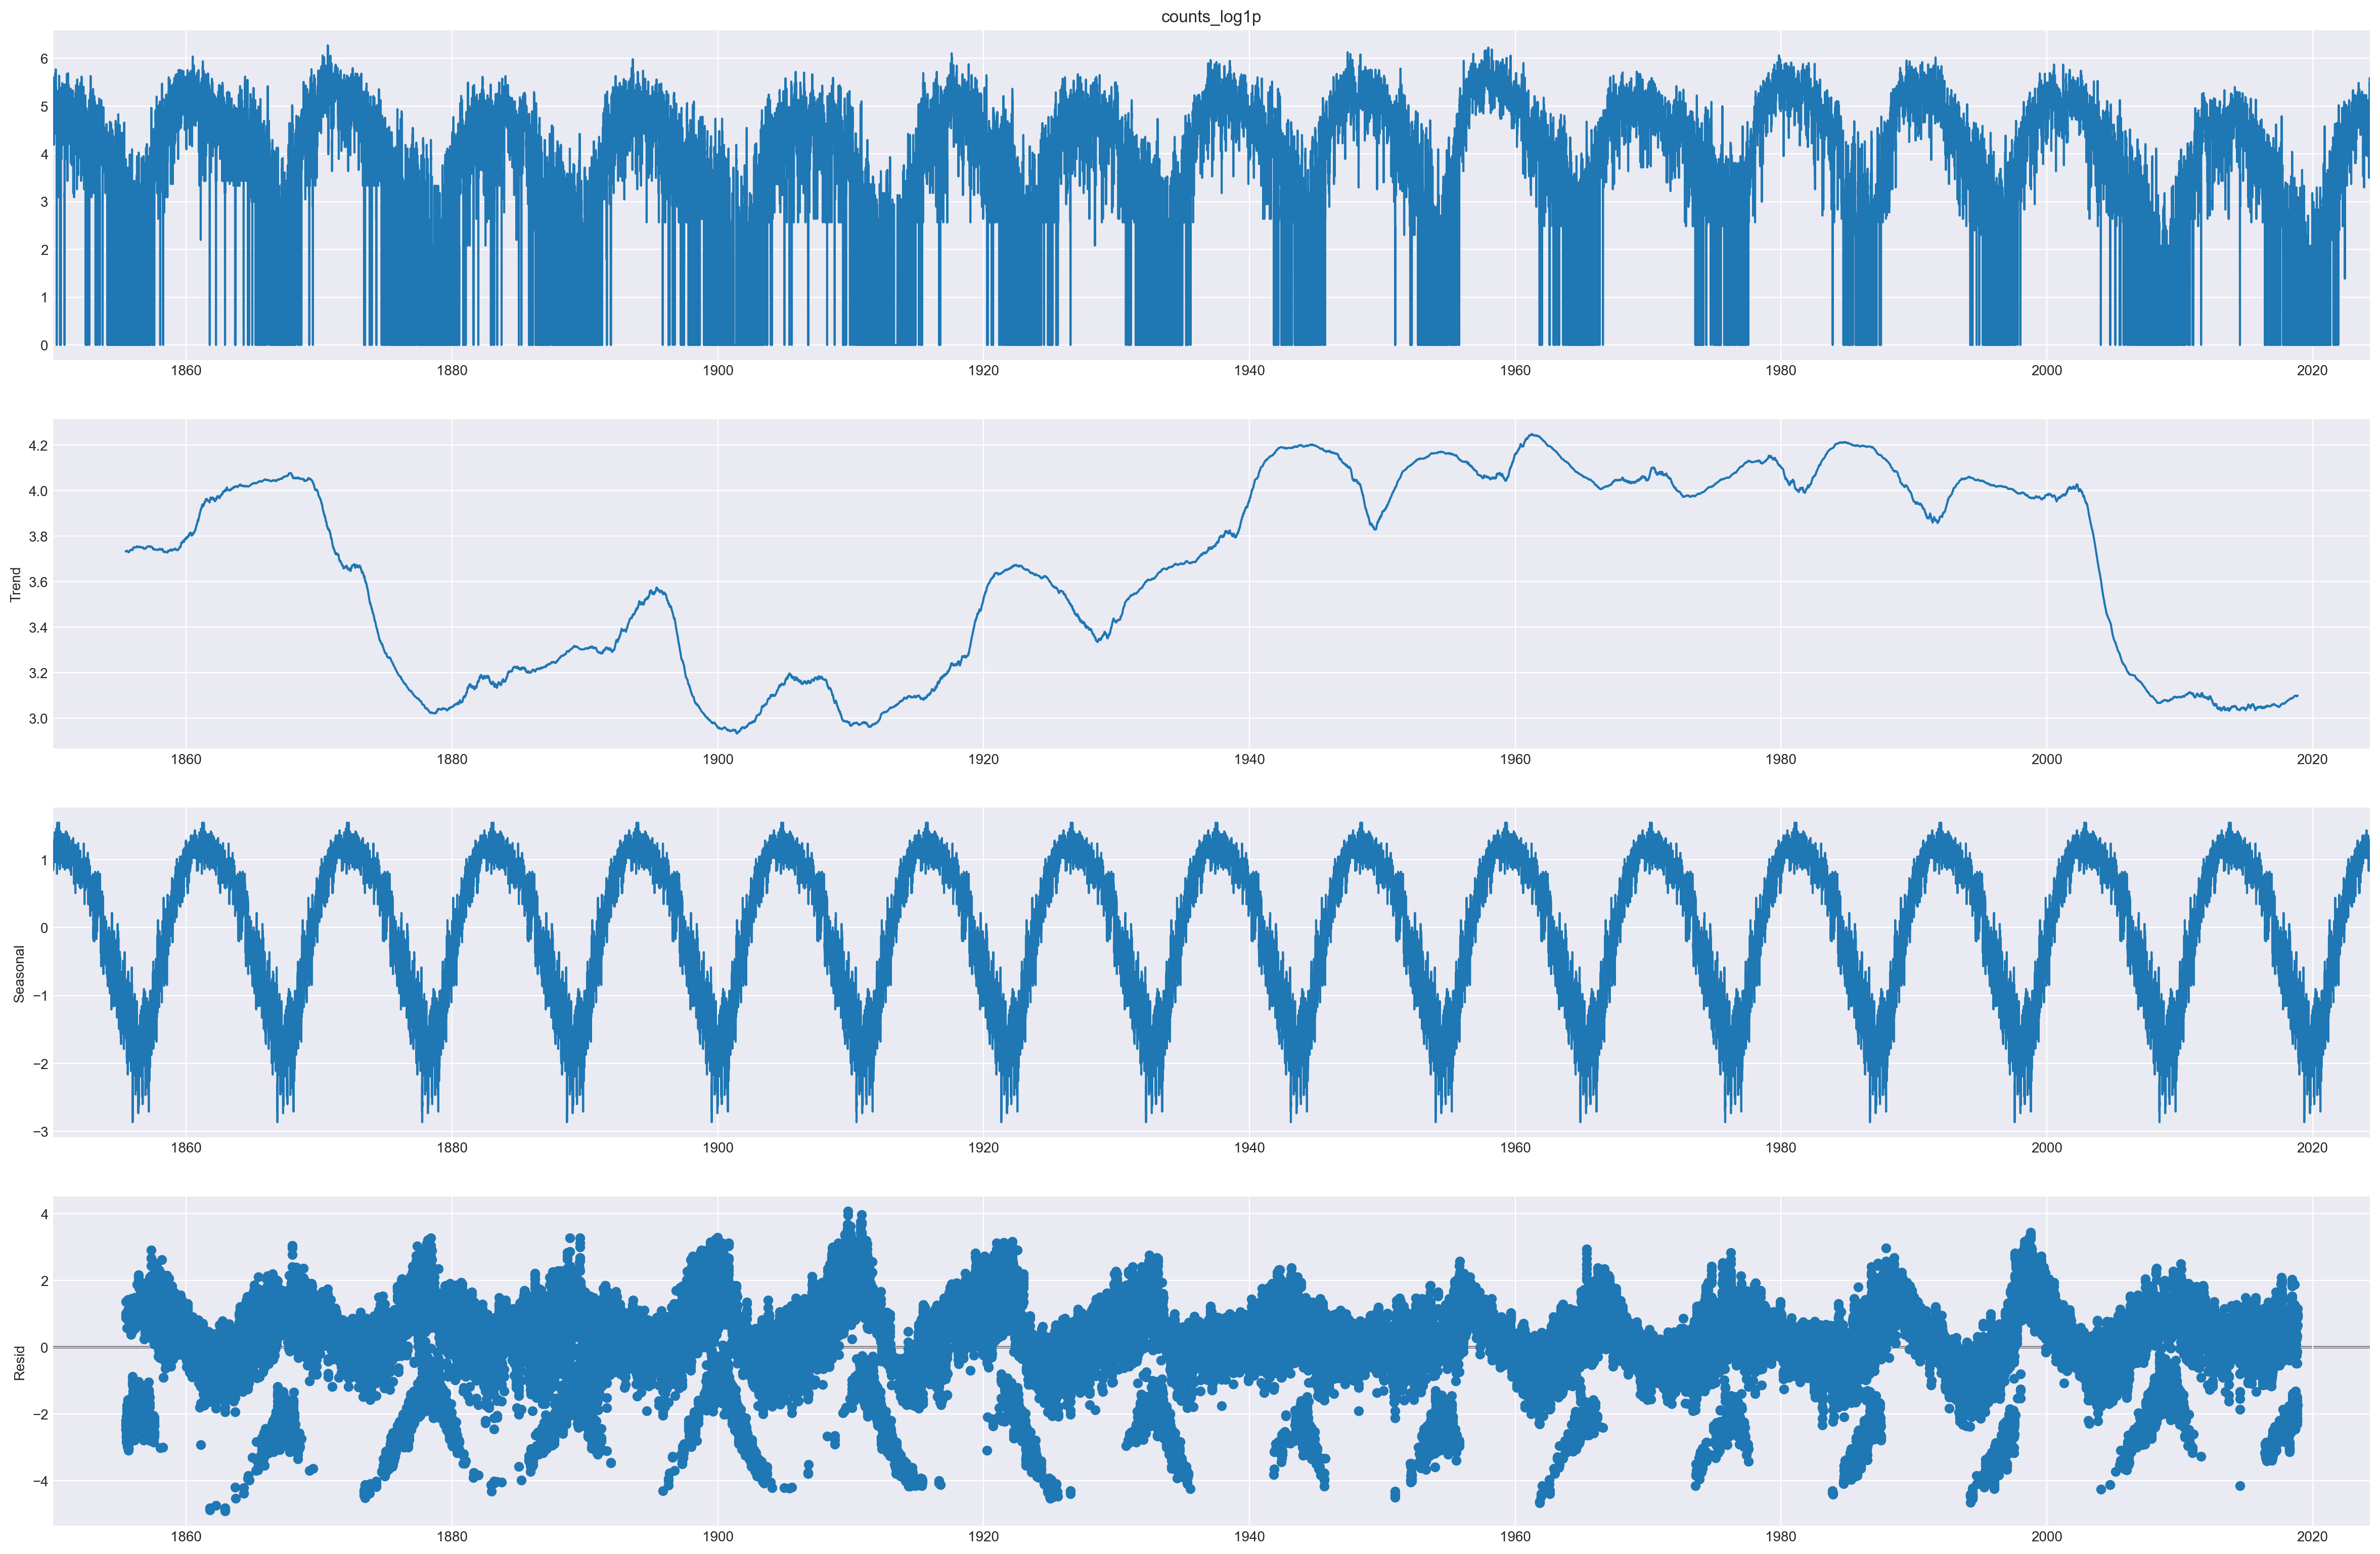

In [21]:
decomposition_t = seasonal_decompose(data.counts_log1p, model = 'add', period = T1)
trend_t = decomposition_t.trend
seasonal_t = decomposition_t.seasonal
residual_t = decomposition_t.resid
fig = decomposition_t.plot()
fig.set_size_inches((24, 16))
plt.show()

In [22]:
qcd_variance(data.counts_log1p)

quartile coefficient of dispersion: 0.18775


*Is the time serie stationary?*

In [23]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def white_homoscedasticity_test(series):
    """
    returns p-value for White's homoscedasticity test
    """
    series = series.reset_index(drop=True).reset_index()
    series.columns = ['time', 'value']
    series['time'] += 1
    
    olsr = ols('value ~ time', series).fit()
    p_value = het_white(olsr.resid, olsr.model.exog)[1]
    
    return round(p_value,6)

def p_values(series):
    """
    returns p-values for ADF and KPSS Tests on a time series
    """
    # p value from Augmented Dickey-Fuller (ADF) Test
    p_adf = adfuller(series, autolag="AIC")[1]
    
    # p value from Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test
    p_kpss = kpss(series, regression="c", nlags="auto")[1]
    
    return round(p_adf,6), round(p_kpss,6)

def test_stationarity(series):
    """
    returns likely conclusions about series stationarity
    """
    # test homoscedasticity
    p_white = white_homoscedasticity_test(series)
    
    if p_white < 0.05:
        print(f"\n non-stationary: heteroscedastic (White test p-value: {p_white}) \n")
    
    # test stationarity
    else:
        p_adf, p_kpss = p_values(series)
        
        # print p-values
        print( f"\n p_adf: {p_adf}, p_kpss: {p_kpss}" )
    
        if (p_adf < 0.05) and (p_kpss >= 0.05):
            print('\n stationary or seasonal-stationary')
            
        elif (p_adf >= 0.1) and (p_kpss < 0.05):
            print('\n difference-stationary')
            
        elif (p_adf < 0.1) and (p_kpss < 0.05):
            print('\n trend-stationary')
        
        else:
            print('\n non-stationary; no robust conclusions\n')
        
test_stationarity(data.counts)



 non-stationary: heteroscedastic (White test p-value: 0.0) 



In [24]:
p_adf = adfuller(data.counts, autolag="AIC")[1]
p_adf

2.9337380565746385e-11

## 2. Using pipelines to study the Time Series

**2.1 BaselineModel**

In [26]:
data = pd.read_csv("../data/daily_sunspots_time_series_1850-01_2024-05.csv", parse_dates=['date'])
data.set_index('date', inplace = True)
data = data.drop(['date_frac', 'std', 'nobs','indicator'], axis = 1)

In [27]:
# Create a new index that repeats every 365 rows and resets every T=3979 rows
# It is going to be useful for seasonality test
new_index = np.arange(data.shape[0])% T1 // 365
data['year_sc'] = new_index

# We will apply 2 transformations: n.log1p and yeojohnson
from scipy import stats
data['counts_log1p'] = np.log1p(data.counts)
data['counts_yj'], _ = stats.yeojohnson(data.counts)
data.head(3)

year  month  day  counts  year_sc  counts_log1p  counts_yj
date                                                                  
1850-01-01  1850      1    1     253        0      5.537334  18.376704
1850-01-02  1850      1    2     162        0      5.093750  15.174810
1850-01-03  1850      1    3     217        0      5.384495  17.213393

let's see the decomposition using Yeo-Johnson Transformation

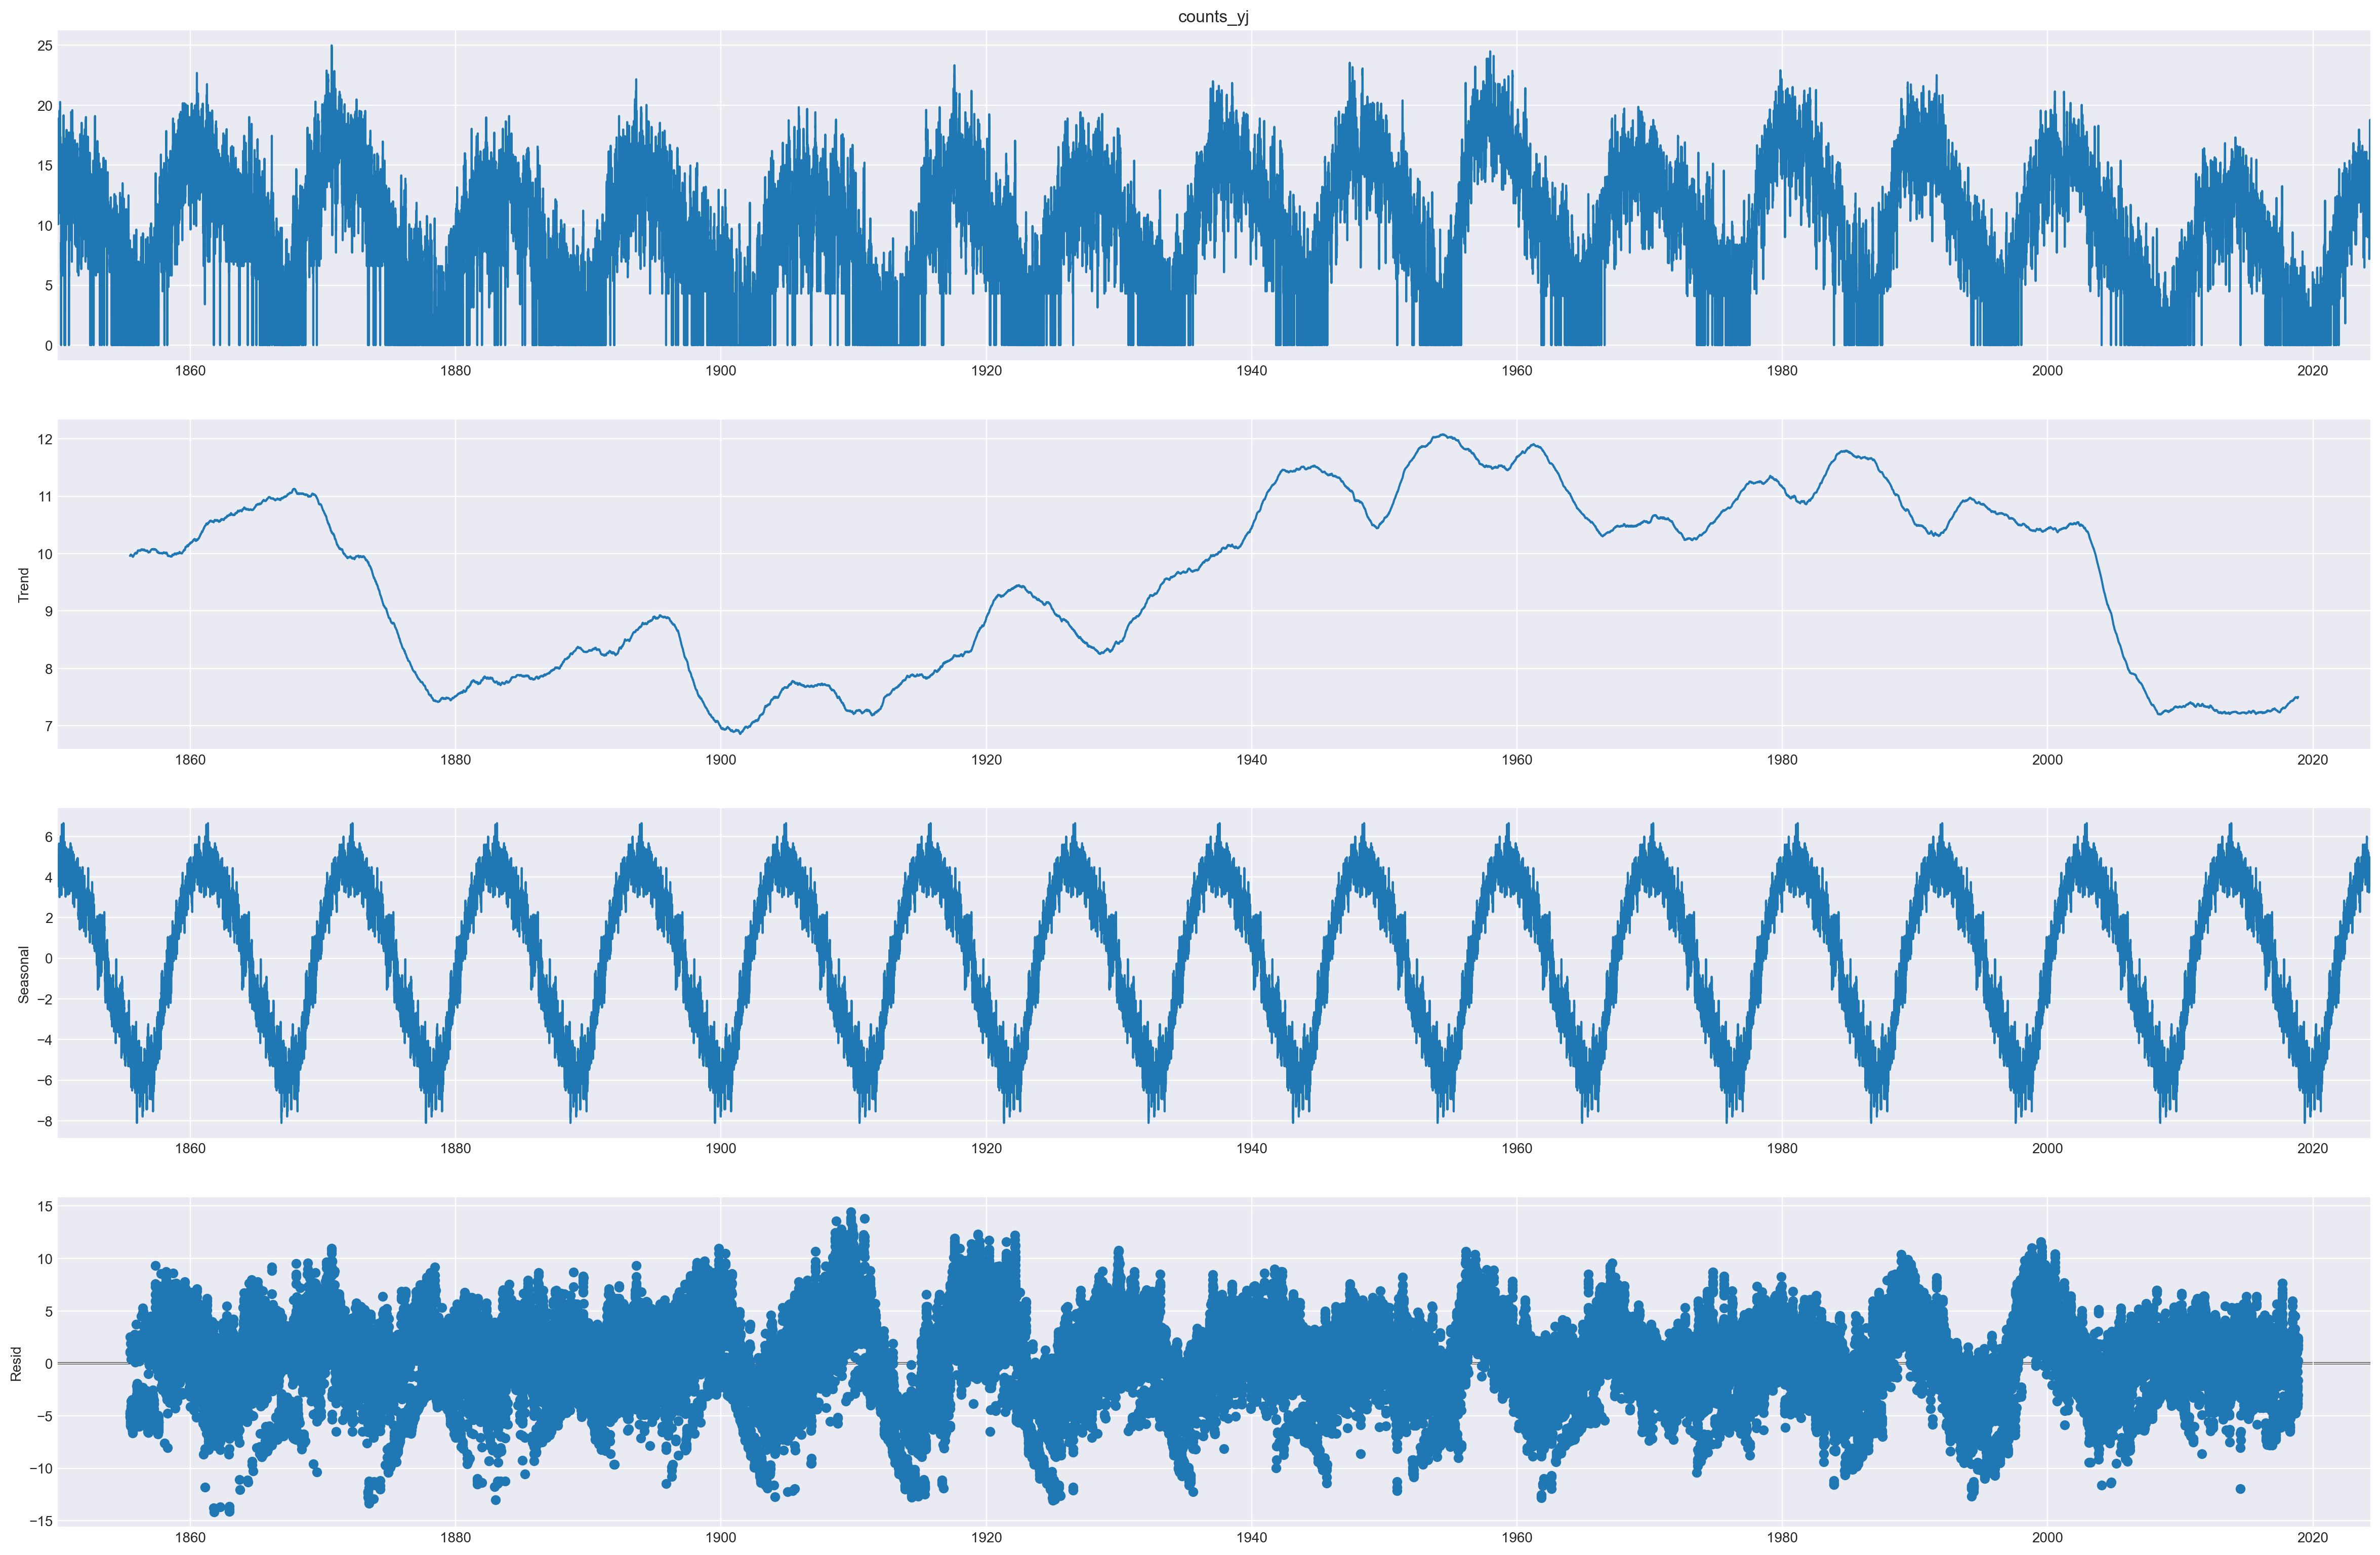

In [29]:
decompoition_yj = seasonal_decompose(data.counts_yj, model = 'add', period = T1)
trend_yj = decompoition_yj.trend
seasonal_yj = decompoition_yj.seasonal
residual_yj = decompoition_yj.resid
fig = decompoition_yj.plot()
fig.set_size_inches((24, 16))
plt.show()

Train-Test Split

In [30]:
test_width = int(0.1*len(data))
train = data.iloc[:-test_width]
test = data.iloc[-test_width:]

train['timestep'] = list(range(train.shape[0]))
test['timestep'] = list(
    range(train.shape[0], train.shape[0]+test.shape[0])
)

print(f'Train shape: {train.shape}, Test Set: {test.shape}')

Train shape: (57306, 8), Test Set: (6367, 8)


counts_yj  trend_baseline
date                                 
1850-01-01  18.376704       11.275578
1850-01-02  15.174810       11.275150
1850-01-03  17.213393       11.274722
1850-01-04  12.208307       11.274294
1850-01-05  12.693206       11.273866

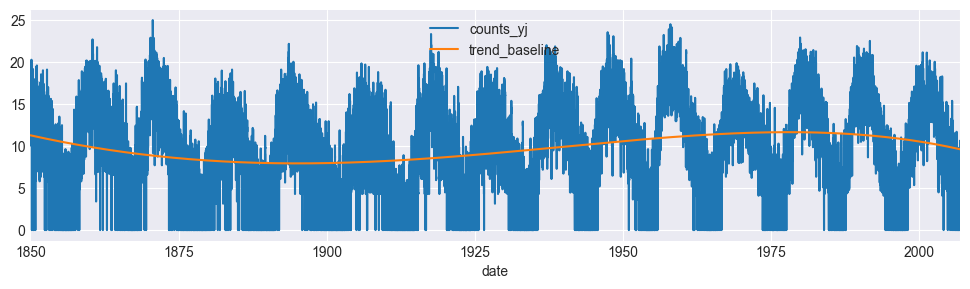

In [31]:
col_transformer = ColumnTransformer([
    ('Poly', PolynomialFeatures(degree = 4), ['timestep']),
    ('ohe', OneHotEncoder(drop='first'), ['year_sc'])
])

model_trend_baseline = Pipeline(steps = [('col_transf', col_transformer),
                            ('LR', LinearRegression())
                            ])

#Feature and target for the baseline model
X_trend_baseline = train[['timestep', 'year_sc']]
Y_trend = train['counts_yj']
model_trend_baseline.fit(X_trend_baseline, Y_trend)

train['trend_baseline'] = model_trend_baseline.predict(X_trend_baseline)
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['counts_yj','trend_baseline']].plot(legend=True)
sns.despine()
train[['counts_yj', 'trend_baseline']].head()



We see that this is not a good approach. We need more details in the model.

**Train-Test split**

In [32]:
test_width = int(0.1*len(data))
train = data.iloc[:-test_width]
test = data.iloc[-test_width:]
print(f'Train shape: {train.shape}, Test Set: {test.shape}')

Train shape: (57306, 7), Test Set: (6367, 7)


In [33]:
train.head()

year  month  day  counts  year_sc  counts_log1p  counts_yj
date                                                                  
1850-01-01  1850      1    1     253        0      5.537334  18.376704
1850-01-02  1850      1    2     162        0      5.093750  15.174810
1850-01-03  1850      1    3     217        0      5.384495  17.213393
1850-01-04  1850      1    4      99        0      4.605170  12.208307
1850-01-05  1850      1    5     108        0      4.691348  12.693206

In [34]:
# Let's engineer a timestep variable for future convenience
train['timestep'] = list(range(train.shape[0]))
test['timestep'] = list(
    range(train.shape[0], train.shape[0]+test.shape[0])
)

#Feature and target for the model
X_train_baseline = train[['timestep', 'year_sc']]
Y_train = train['counts']

**Baselinemodel: Trend-Seasonality decomposition with Poly(n)**

In [35]:
from sklearn.compose import TransformedTargetRegressor

# Feature Transformer
col_transformer = ColumnTransformer([
    ('Poly', PolynomialFeatures(degree = 4), ['timestep']),
    ('ohe', OneHotEncoder(drop='first'), ['year_sc'])
])

pipeline_trend = Pipeline(steps = [('col_transf', col_transformer),
                            ('LR', LinearRegression())
                            ])

# Target Transformer
model = TransformedTargetRegressor(
    regressor = pipeline_trend,
    func = np.log1p, 
    inverse_func= np.expm1
)

model.fit(X_train_baseline, Y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('col_transf',
                                                      ColumnTransformer(transformers=[('Poly',
                                                                                       PolynomialFeatures(degree=4),
                                                                                       ['timestep']),
                                                                                      ('ohe',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['year_sc'])])),
                                                     ('LR',
                                                      LinearRegression())]))

## Predicting the model

*1. TREND*

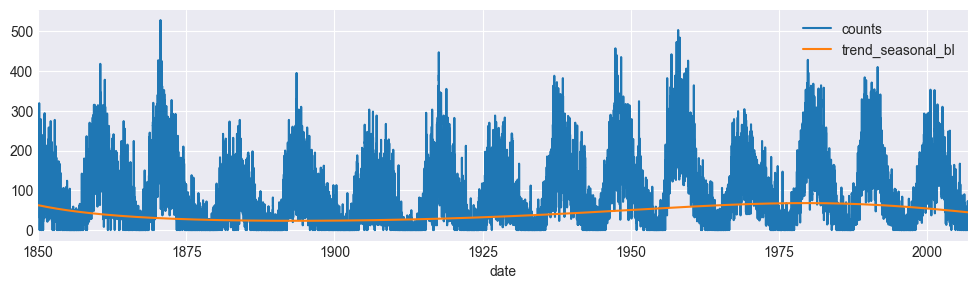

In [36]:
train['trend_seasonal_bl'] = model.predict(X_train_baseline)
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['counts','trend_seasonal_bl']].plot(legend=True)
sns.despine()

In [37]:
train[['counts', 'trend_seasonal_bl']].head()

counts  trend_seasonal_bl
date                                 
1850-01-01     253          62.575759
1850-01-02     162          62.567230
1850-01-03     217          62.558704
1850-01-04      99          62.550179
1850-01-05     108          62.541657

*Remainder*

In [38]:
train['remainder'] = train['counts'] - train['trend_seasonal_bl']

Feature and target

In [40]:
X_seasonality = train[['timestep','year']]
#Y_seasonality = train['detrended']

In [41]:
seasonality_model = make_pipeline(
    OneHotEncoder(drop = 'first'),
    LinearRegression()
)

seasonality_model.fit(X_seasonality, Y_seasonality)

NameError: name 'Y_seasonality' is not defined

In [511]:
train['seasonality'] = seasonality_model.predict(X_seasonality)

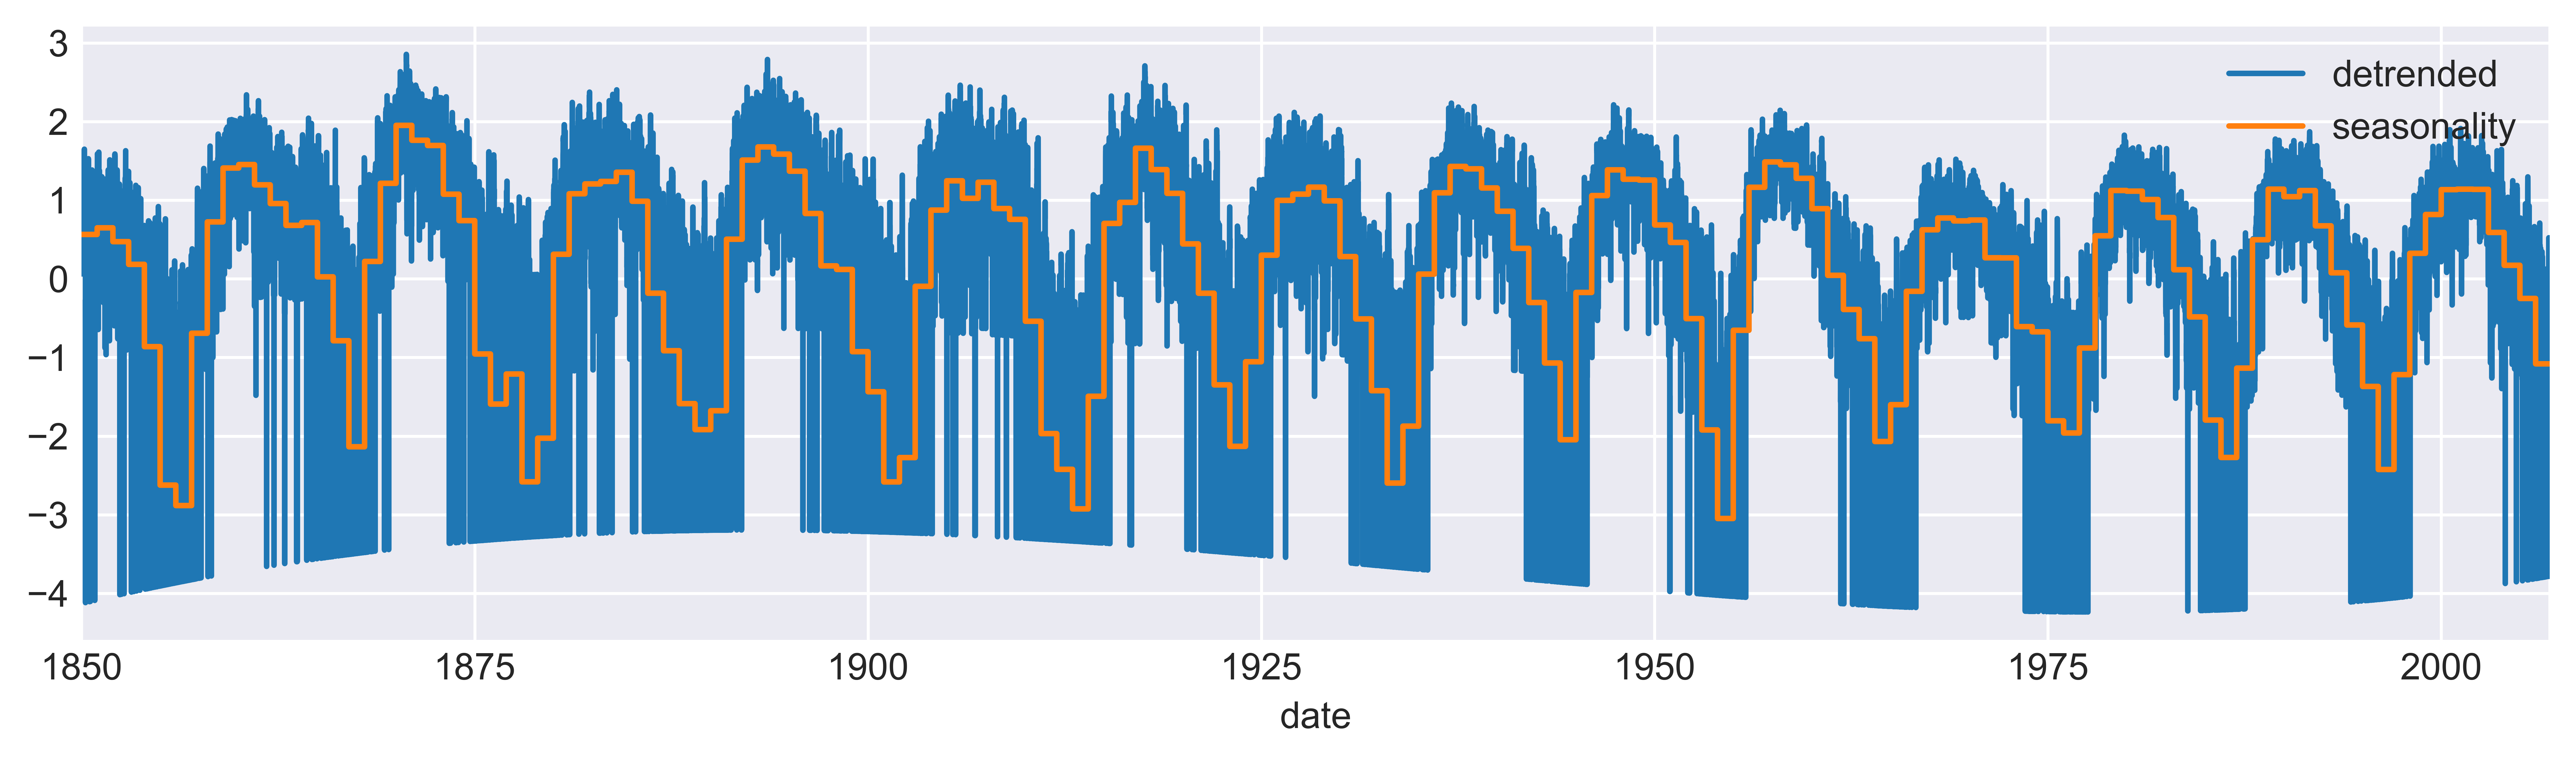

In [512]:
mpl.rc('figure',figsize=(12,3),dpi=1000)

train[['detrended','seasonality']].plot(legend=True)
sns.despine()

If we create a 11-year index?

In [387]:
"""
X_seasonality_sc = train[['year_sc']]
Y_seasonality_sc = train['detrended']
seasonality_sc_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)
seasonality_sc_model.fit(X_seasonality_sc, Y_seasonality_sc)
train['seasonality_sc'] = seasonality_sc_model.predict(X_seasonality_sc)
mpl.rc('figure',figsize=(12,3),dpi=1000)

train[['detrended','seasonality_sc']].plot(legend=True)
sns.despine()
"""

"\nX_seasonality_sc = train[['year_sc']]\nY_seasonality_sc = train['detrended']\nseasonality_sc_model = make_pipeline(\n    OneHotEncoder(drop='first'),\n    LinearRegression()\n)\nseasonality_sc_model.fit(X_seasonality_sc, Y_seasonality_sc)\ntrain['seasonality_sc'] = seasonality_sc_model.predict(X_seasonality_sc)\nmpl.rc('figure',figsize=(12,3),dpi=1000)\n\ntrain[['detrended','seasonality_sc']].plot(legend=True)\nsns.despine()\n"

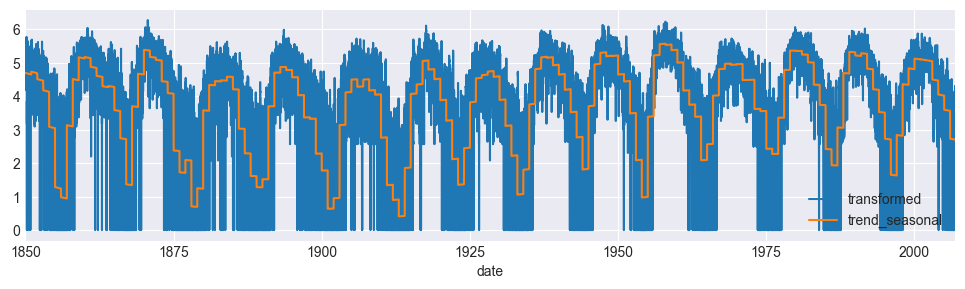

In [462]:
train['trend_seasonal'] = train['trend'] + train['seasonality']
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['transformed','trend_seasonal']].plot(legend=True)
sns.despine()

*Remainded*

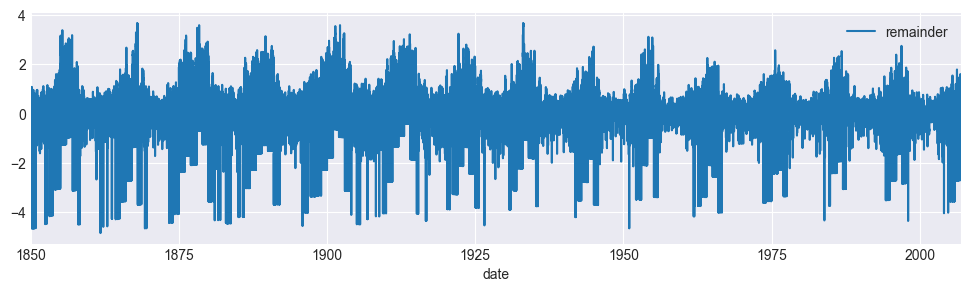

In [463]:
train['remainder'] = train['transformed'] - train['trend_seasonal']
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

*We see that we need additional methods to extract some information from the data*

## Time Based CV
Time series split for cross validation applied only to the train set!

In [42]:
# DATA PREPARATION

data = pd.read_csv("../data/daily_sunspots_time_series_1850-01_2024-05.csv", parse_dates=['date'])
data.set_index('date', inplace = True)
data = data.drop(['date_frac', 'std', 'nobs','indicator'], axis = 1)

# Let's try with smoothed values first
#data['counts_smoothed'] = low_pass(data['counts'])
#data['counts_log1p'] = np.log1p(data['counts_smoothed'])
#data['counts_yj'], _ = stats.yeojohnson(data['counts_smoothed'])
# Otherwise:
data['counts_log1p'] = np.log1p(data['counts'])
data['counts_yj'], _ = stats.yeojohnson(data['counts'])



# New Index for the year in the solarcycle
new_index = np.arange(data.shape[0])% T1 // 365
data['year_sc'] = new_index

test_width = int(0.1*len(data))
train = data.iloc[:-test_width]
test = data.iloc[-test_width:]



train['timestep'] = list(range(train.shape[0]))
test['timestep'] = list(
    range(train.shape[0], train.shape[0]+test.shape[0])
)

print(f'Train shape: {train.shape}, Test Set: {test.shape}')

Train shape: (57306, 8), Test Set: (6367, 8)


In [43]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits = 5,
    gap = 0,
    max_train_size = None,
    test_size = None
)

# We can inspect the 5 split to see how they look like
X_train_cv = train[['timestep', 'day']]
Y_train_cv = train['counts_log1p']
#Y_train_cv = train['counts_yj']
all_splits = list(ts_cv.split(X_train_cv, Y_train_cv))

In [44]:
# Let's check the splits
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

We see that the seasonality and trend is hard to model by a simple polynomial regression model.
Let's introduce trigonometric features to capture the periodicity of the data

In [45]:
from sklearn.preprocessing import FunctionTransformer
def sin_feature(period):
    return FunctionTransformer(lambda t: np.sin((2*np.pi/period)*t))
                               
def cos_feature(period):
    return FunctionTransformer(lambda t: np.cos((2*np.pi/period)*t))

## GridSearch With Trigonometric Functions

In [55]:
param_grid = {'transformer__poly__degree': [1,2,3,4,5,6]}

# Feature transformation
cyclic_cossin_transformer = ColumnTransformer(
    transformers = [
        ("sin1", sin_feature(T1), ['timestep']),
        ("cos1", cos_feature(T1), ['timestep']),
        ("sin2", sin_feature(T2), ['timestep']),
        ("cos2", cos_feature(T2), ['timestep']),
        ('poly', PolynomialFeatures(),['timestep'])#,
        #('ohe', OneHotEncoder(drop='first'), ['day'])
        ]
    )

estimator_trigonometric = Pipeline(steps = [
    ('transformer', cyclic_cossin_transformer),
    ('LR', LinearRegression())

])

gscv = GridSearchCV(
    estimator = estimator_trigonometric,
    param_grid = param_grid,
    scoring = 'r2',
    cv = ts_cv,
    n_jobs = -1
)

# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X_train_cv,Y_train_cv)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

time taken: 0.16 sec


In [56]:
gscv.cv_results_

{'mean_fit_time': array([0.00691576, 0.00675764, 0.00612183, 0.00631628, 0.00638614,
        0.00674763]),
 'std_fit_time': array([0.00188159, 0.00166184, 0.00145487, 0.00188548, 0.00201907,
        0.00176947]),
 'mean_score_time': array([0.00197983, 0.00180144, 0.00170856, 0.00165563, 0.00176578,
        0.00177321]),
 'std_score_time': array([2.30825585e-04, 1.12133345e-04, 8.90402457e-05, 1.00305436e-04,
        1.48769479e-04, 1.39514485e-04]),
 'param_transformer__poly__degree': masked_array(data=[1, 2, 3, 4, 5, 6],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'transformer__poly__degree': 1},
  {'transformer__poly__degree': 2},
  {'transformer__poly__degree': 3},
  {'transformer__poly__degree': 4},
  {'transformer__poly__degree': 5},
  {'transformer__poly__degree': 6}],
 'split0_test_score': array([ 2.26074357e-01, -2.30199014e+00, -6.29069757e+01, -7.54574930e+02,
        -2.03300103e+04, -1.24443

In [57]:
column_list = ['param_transformer__poly__degree',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

result_df.rename(
    columns=lambda name: name.split('__')[-1],inplace=True
)
result_df

degree  mean_test_score  std_test_score  rank_test_score
0      1         0.100107        0.109517                1
1      2        -0.495038        0.968789                2
2      3       -13.085481       24.923033                3
3      4      -182.786424      291.369275                4
4      5     -4654.685681     7916.683252                5
5      6   -252055.502913   496227.678677                6

In [58]:
gscv.best_params_

{'transformer__poly__degree': 1}

In [59]:
model_cv = gscv.best_estimator_
model_cv.fit(X_train_cv, Y_train_cv)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('sin1',
                                                  FunctionTransformer(func=<function sin_feature.<locals>.<lambda> at 0x32959aac0>),
                                                  ['timestep']),
                                                 ('cos1',
                                                  FunctionTransformer(func=<function cos_feature.<locals>.<lambda> at 0x3bcbe63e0>),
                                                  ['timestep']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['timestep'])])),
                ('LR', LinearRegression())])

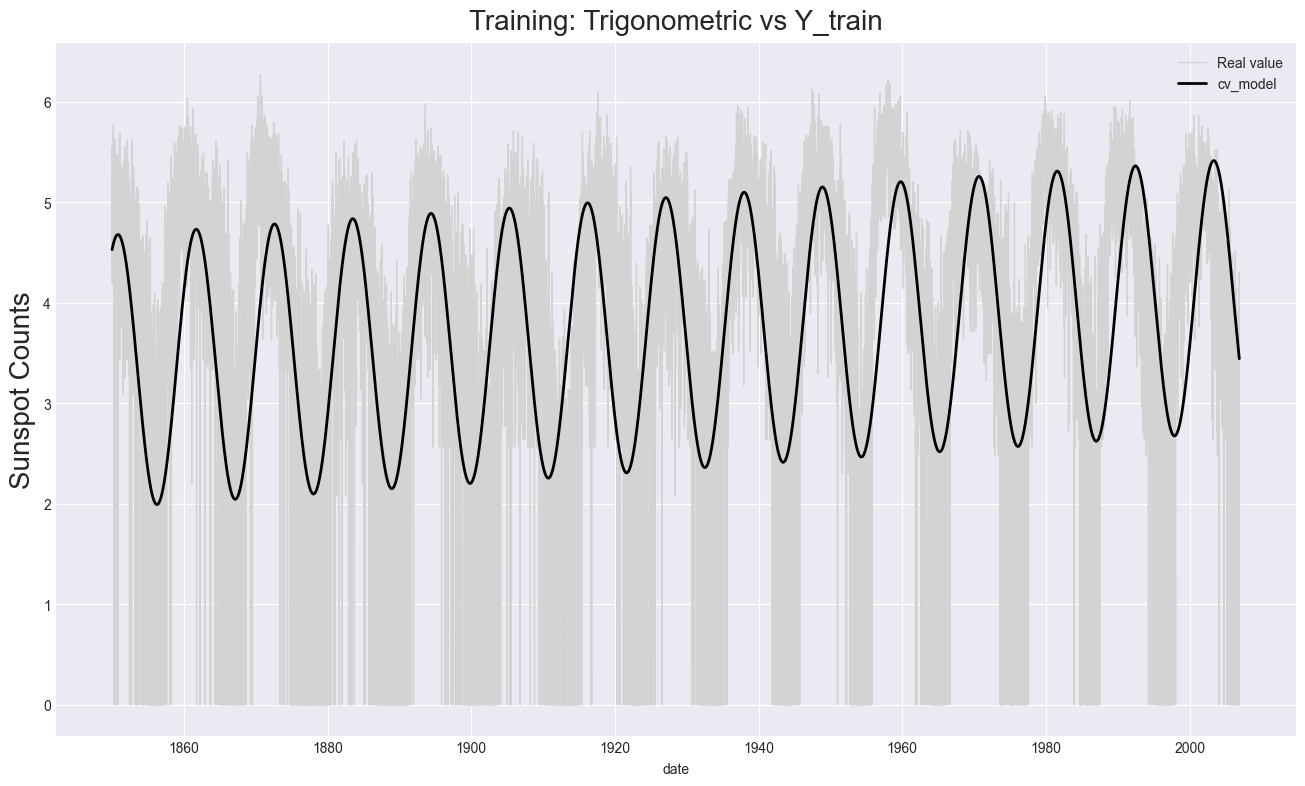

In [69]:
train['cv_baseline'] = model_cv.predict(X_train_cv)
fig = plt.figure(figsize=(16,9))
plt.plot(train['counts_log1p'], linewidth=1, color = 'lightgrey')
plt.plot(train['cv_baseline'], linewidth=2, color = 'black')
plt.xlabel('date',fontsize=10, labelpad=5)
plt.ylabel('Sunspot Counts',fontsize=20, labelpad=5)
plt.legend(['Real value','cv_model'], prop={'size': 10})
plt.title('Training: Trigonometric vs Y_train',fontsize=20, pad=10)                  
plt.show()

**FORECAST**

In [60]:
X_test = test[['timestep', 'day']]
test['cv_baseline'] = model_cv.predict(X_test)

In [61]:
test[['counts_log1p', 'cv_baseline']].head()

counts_log1p  cv_baseline
date                                 
2006-11-25      2.639057     3.441731
2006-11-26      2.772589     3.439851
2006-11-27      3.526361     3.437972
2006-11-28      3.663562     3.436094
2006-11-29      3.713572     3.434218

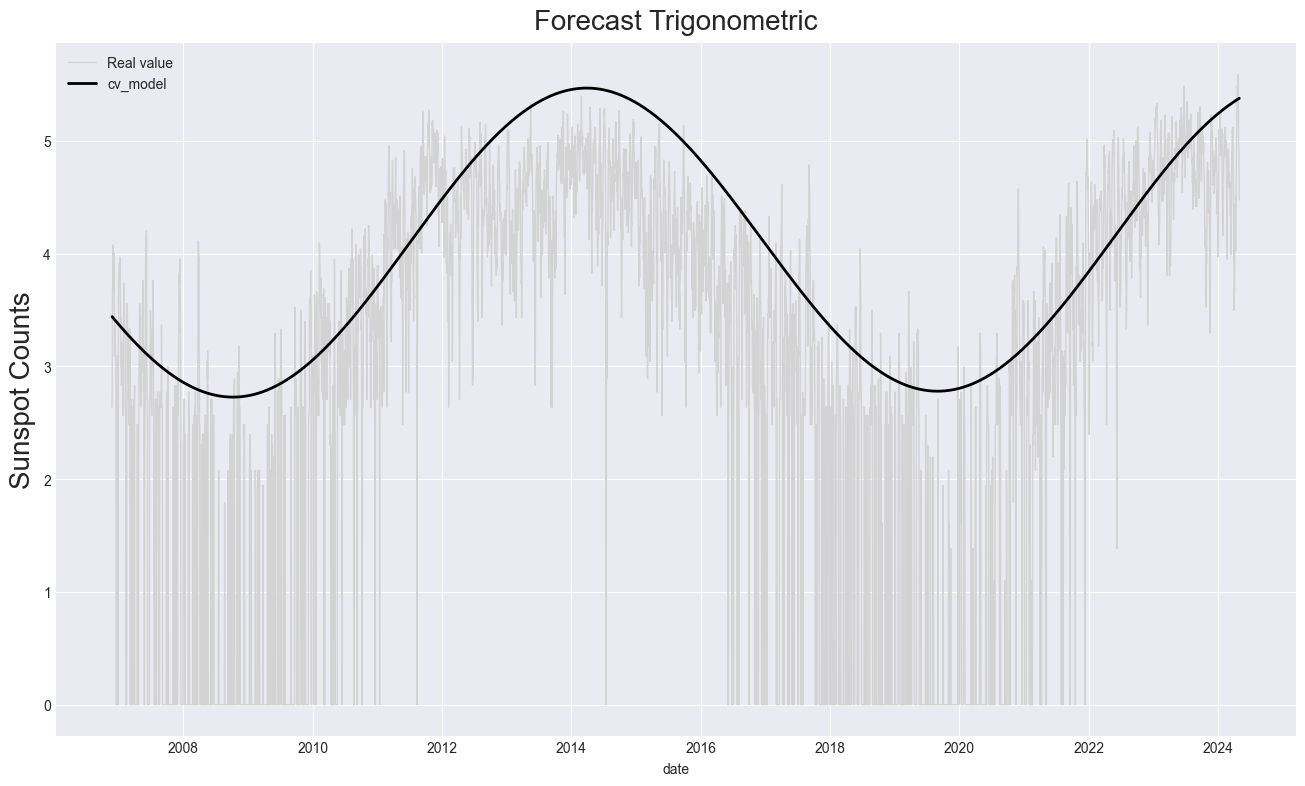

In [71]:
fig = plt.figure(figsize=(16,9))
plt.plot(test['counts_log1p'], linewidth=1, color = 'lightgrey')
plt.plot(test['cv_baseline'], linewidth=2, color = 'black')
plt.xlabel('date',fontsize=10, labelpad=5)
plt.ylabel('Sunspot Counts',fontsize=20, labelpad=5)
plt.legend(['Real value','cv_model'], prop={'size': 10})
plt.title('Forecast Trigonometric',fontsize=20, pad=10)                  
plt.show()

In [63]:
r2_bimp = round(model_cv.score(X_test,test['counts_yj']),6)
print(f"r2_score: {r2_bimp}")

r2_score: -0.075023


REMAINDER

In [72]:
train['remainder'] = train['counts_log1p'] - model_cv.predict(train)

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

In [906]:
from sklearn.compose import TransformedTargetRegressor

# Feature Transformer
cyclic_cossin_transformer = ColumnTransformer(
    transformers = [
        ("sin1", sin_feature(T1), ['timestep']),
        ("cos1", cos_feature(T1), ['timestep']),
        ("sin2", sin_feature(T2), ['timestep']),
        ("cos2", cos_feature(T2), ['timestep']),
        ('poly', PolynomialFeatures(),['timestep']),
        ('ohe', OneHotEncoder(drop='first'), ['year_sc'])
        ]
    )

estimator_trigonometric = Pipeline(steps = [
    ('transformer', cyclic_cossin_transformer),
    ('LR', LinearRegression())

])

model_pipe = Pipeline([
    'model_target', TransformedTargetRegressor(
    regressor = estimator_trigonometric,
    func = np.log1p, 
    inverse_func= np.expm1
)
])

############################## 
# Target Transformer
target_model = TransformedTargetRegressor(
    regressor = estimator_trigonometric,
    func = np.log1p, 
    inverse_func= np.expm1
)
gscv = GridSearchCV(
    estimator = estimator_trigonometric,
    param_grid = param_grid,
    scoring = 'r2',
    cv = ts_cv,
    n_jobs = -1
)
target_model.fit(X_train_baseline, Y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('transformer',
                                                      ColumnTransformer(transformers=[('sin1',
                                                                                       FunctionTransformer(func=<function sin_feature.<locals>.<lambda> at 0x35881e7a0>),
                                                                                       ['timestep']),
                                                                                      ('cos1',
                                                                                       FunctionTransformer(func=<function cos_feature.<locals>.<lambda> at 0x35881f060>),
                                                                                       ['timestep']),
                                                                                      ('sin2',
                                                                                       FunctionTransformer(func=<function sin_feature.<locals>.<lambda> at 0x35881eb60>),
                                                                                       ['timestep']),
                                                                                      ('cos2',
                                                                                       FunctionTransformer(func=<function cos_feature.<locals>.<lambda> at 0x35881e700>),
                                                                                       ['timestep']),
                                                                                      ('poly',
                                                                                       PolynomialFeatures(),
                                                                                       ['timestep']),
                                                                                      ('ohe',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['year_sc'])])),
                                                     ('LR',
                                                      LinearRegression())]))

In [903]:
# initial time
ti = time.time()

# grid-search cross-validation
target_model.fit(X_train_cv,Y_train_cv)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

time taken: 0.03 sec


In [907]:
target_model.cv_results_

AttributeError: 'TransformedTargetRegressor' object has no attribute 'cv_results_'

In [899]:
column_list = ['param_transformer__poly__degree',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

result_df.rename(
    columns=lambda name: name.split('__')[-1],inplace=True
)
result_df

degree  mean_test_score  std_test_score  rank_test_score
0      1         0.070767        0.145067                1
1      2        -0.573012        1.121269                2
2      3       -28.655958       55.982433                3
3      4      -140.868929      209.732168                4
4      5     -4654.494392     7916.615078                5
5      6   -252050.182725   496217.650440                6

In [900]:
gscv.best_params_

{'transformer__poly__degree': 1}

In [901]:
baseline_model_cv = gscv.best_estimator_
baseline_model_cv.fit(X_train_cv, Y_train_cv)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('sin1',
                                                  FunctionTransformer(func=<function sin_feature.<locals>.<lambda> at 0x32bfe3880>),
                                                  ['timestep']),
                                                 ('cos1',
                                                  FunctionTransformer(func=<function cos_feature.<locals>.<lambda> at 0x173e4ca40>),
                                                  ['timestep']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['timestep']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['year_sc'])])),
                ('LR', LinearRegression())])

In [902]:
test['baseline_pred_cv'] = baseline_model_cv.predict(test)